In [1]:
import tensorflow as tf

# load dataset
(x_train, _), (x_test, _) = tf.keras.datasets.fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Budowa autokodera kontraktywnego (CAE)

In [2]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.flatten_layer = tf.keras.layers.Flatten(name="flatten")
        self.dense1 = tf.keras.layers.Dense(64, activation=tf.nn.relu, name="encoder_dense1")
        self.dense2 = tf.keras.layers.Dense(32, activation=tf.nn.relu, name="encoder_dense2")
        self.bottleneck = tf.keras.layers.Dense(16, activation=tf.nn.relu, name="bottleneck")
        self.dense4 = tf.keras.layers.Dense(32, activation=tf.nn.relu, name="decoder_dense1")
        self.dense5 = tf.keras.layers.Dense(64, activation=tf.nn.relu, name="decoder_dense2")
        self.dense_final = tf.keras.layers.Dense(784, name="decoder_output")

    def call(self, inp):
        x_reshaped = self.flatten_layer(inp)
        x = self.dense1(x_reshaped)
        x = self.dense2(x)
        x = self.bottleneck(x)
        x_hid= x
        x = self.dense4(x)
        x = self.dense5(x)
        x = self.dense_final(x)
        return x, x_reshaped,x_hid


## Funkcja straty

In [3]:
# define loss function and gradient
def loss(x, x_bar, h, model, Lambda =100):
    reconstruction_loss = tf.reduce_mean(
                tf.keras.losses.mse(x, x_bar)
            )
    reconstruction_loss *= 28 * 28
    W= tf.Variable(model.bottleneck.weights[0])
    dh = h * (1 - h)  # N_batch x N_hidden
    W = tf.transpose(W)
    contractive = Lambda * tf.reduce_sum(tf.linalg.matmul(dh**2,
                                                          tf.square(W)),
                                         axis=1)
    total_loss = reconstruction_loss + contractive
    return total_loss


##  Gradient

In [4]:
def grad(model, inputs):
    with tf.GradientTape() as tape:
        reconstruction, inputs_reshaped, hidden = model(inputs)
        loss_value = loss(inputs_reshaped, reconstruction, hidden, model)
    return loss_value, tape.gradient(loss_value, model.trainable_variables), inputs_reshaped, reconstruction


## Trenowanie modelu



In [ ]:

model = AutoEncoder()
optimizer = tf.optimizers.Adam(learning_rate=0.001)
global_step = tf.Variable(0)
num_epochs = 20
batch_size = 128

# List to store loss values for each epoch
loss_history = []

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    epoch_loss = 0  # Initialize loss for the epoch
    for x in range(0, len(x_train), batch_size):
        x_inp = x_train[x : x + batch_size]
        loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_loss += tf.reduce_sum(loss_value).numpy()  # Accumulate batch loss

    # Average loss for the epoch
    epoch_loss /= len(x_train)
    loss_history.append(epoch_loss)  # Store epoch loss
    print("Step: {}, Loss: {:.4f}".format(global_step.numpy(), epoch_loss))




Epoch:  0
Step: 0, Loss: 49.1700
Epoch:  1
Step: 0, Loss: 31.9008
Epoch:  2
Step: 0, Loss: 28.4361
Epoch:  3
Step: 0, Loss: 26.3921
Epoch:  4
Step: 0, Loss: 25.5158
Epoch:  5
Step: 0, Loss: 24.7201
Epoch:  6
Step: 0, Loss: 23.9187
Epoch:  7
Step: 0, Loss: 23.2889
Epoch:  8
Step: 0, Loss: 22.2677
Epoch:  9
Step: 0, Loss: 21.3725
Epoch:  10
Step: 0, Loss: 20.8807
Epoch:  11
Step: 0, Loss: 20.4569
Epoch:  12
Step: 0, Loss: 20.1105
Epoch:  13
Step: 0, Loss: 19.8833
Epoch:  14
Step: 0, Loss: 19.7653
Epoch:  15
Step: 0, Loss: 19.6582
Epoch:  16
Step: 0, Loss: 19.4718
Epoch:  17
Step: 0, Loss: 19.3226
Epoch:  18
Step: 0, Loss: 19.1824
Epoch:  19
Step: 0, Loss: 19.3217


In [7]:
model = AutoEncoder()
optimizer = tf.optimizers.Adam(learning_rate=0.001)
global_step = tf.Variable(0)
num_epochs = 20
batch_size = 128

# Listy do przechowywania strat
train_loss_history = []
test_loss_history = []

for epoch in range(num_epochs):
    print("Epoch: ", epoch)
    epoch_train_loss = 0  # Inicjalizacja straty dla zbioru treningowego
    epoch_test_loss = 0   # Inicjalizacja straty dla zbioru testowego

    # Trening na zbiorze treningowym
    for x in range(0, len(x_train), batch_size):
        x_inp = x_train[x : x + batch_size]
        loss_value, grads, inputs_reshaped, reconstruction = grad(model, x_inp)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        epoch_train_loss += tf.reduce_sum(loss_value).numpy()  # Akumulacja straty

    # Testowanie na zbiorze testowym
    for x in range(0, len(x_test), batch_size):
        x_inp = x_test[x : x + batch_size]
        reconstruction, inputs_reshaped, hidden = model(x_inp)
        test_loss = loss(inputs_reshaped, reconstruction, hidden, model)
        epoch_test_loss += tf.reduce_sum(test_loss).numpy()

    # Średnia strata dla epoki
    epoch_train_loss /= len(x_train)
    epoch_test_loss /= len(x_test)

    train_loss_history.append(epoch_train_loss)
    test_loss_history.append(epoch_test_loss)

    print(f"Epoch {epoch+1}: Train Loss = {epoch_train_loss:.4f}, Test Loss = {epoch_test_loss:.4f}")


Epoch:  0
Epoch 1: Train Loss = 50.5280, Test Loss = 35.7643
Epoch:  1
Epoch 2: Train Loss = 33.5000, Test Loss = 31.5459
Epoch:  2
Epoch 3: Train Loss = 30.6758, Test Loss = 30.0412
Epoch:  3
Epoch 4: Train Loss = 29.3776, Test Loss = 28.4264
Epoch:  4
Epoch 5: Train Loss = 27.8703, Test Loss = 27.1130
Epoch:  5
Epoch 6: Train Loss = 26.4982, Test Loss = 25.8202
Epoch:  6
Epoch 7: Train Loss = 25.2132, Test Loss = 24.7918
Epoch:  7
Epoch 8: Train Loss = 24.4442, Test Loss = 24.1765
Epoch:  8
Epoch 9: Train Loss = 23.9569, Test Loss = 23.7479
Epoch:  9
Epoch 10: Train Loss = 23.6153, Test Loss = 23.4353
Epoch:  10
Epoch 11: Train Loss = 23.2421, Test Loss = 23.3113
Epoch:  11
Epoch 12: Train Loss = 22.9734, Test Loss = 22.8564
Epoch:  12
Epoch 13: Train Loss = 22.6507, Test Loss = 22.4447
Epoch:  13
Epoch 14: Train Loss = 21.9956, Test Loss = 21.8394
Epoch:  14
Epoch 15: Train Loss = 21.4848, Test Loss = 21.4761
Epoch:  15
Epoch 16: Train Loss = 21.1345, Test Loss = 21.3171
Epoch:  16








## Wyniki



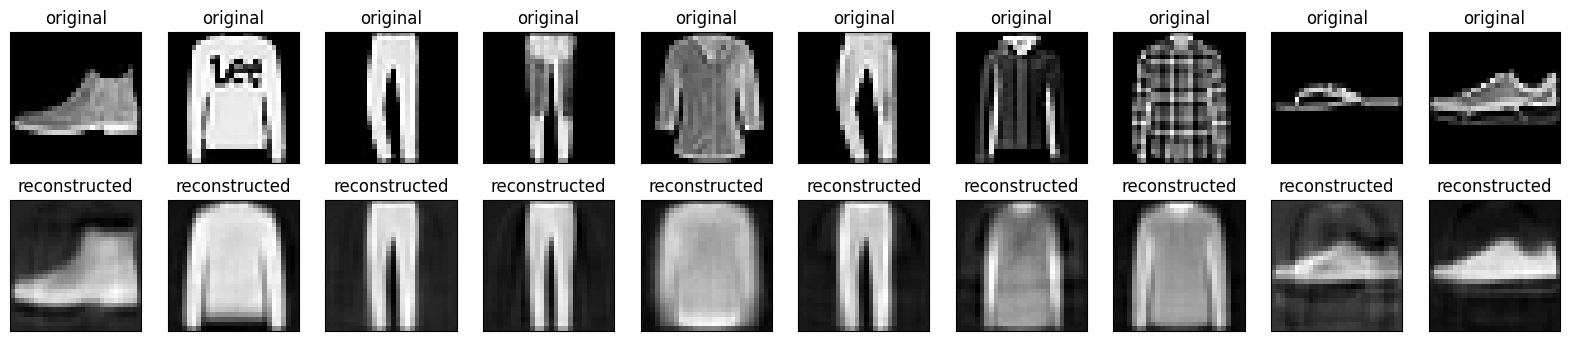

In [8]:
# generate results
n = 10
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  reconstruction, inputs_reshaped,hidden = model(x_test[i].reshape((1,784)))
  plt.imshow(reconstruction.numpy().reshape((28,28)))
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


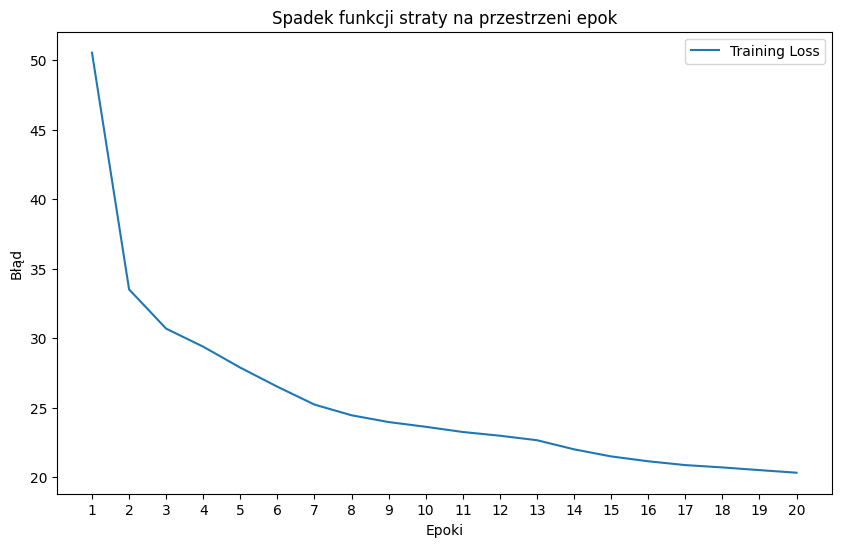

In [11]:
# Plot training loss history
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, label="Training Loss")
plt.title("Spadek funkcji straty na przestrzeni epok")
plt.xlabel("Epoki")
plt.ylabel("Błąd")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.show()

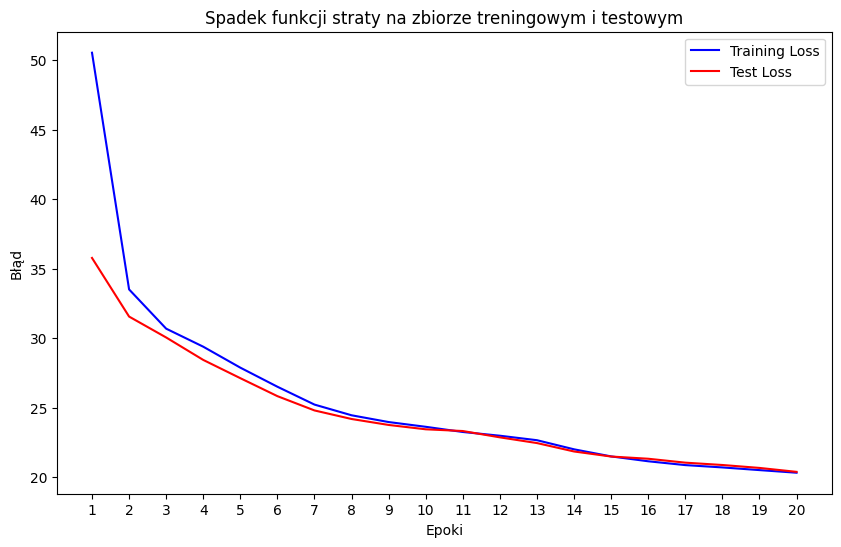

In [9]:
# Wykres strat dla zbioru treningowego i testowego
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_loss_history, label="Training Loss", color="blue")
plt.plot(range(1, num_epochs + 1), test_loss_history, label="Test Loss", color="red")
plt.title("Spadek funkcji straty na zbiorze treningowym i testowym")
plt.xlabel("Epoki")
plt.ylabel("Błąd")
plt.xticks(range(1, num_epochs + 1))
plt.legend()
plt.show()

In [ ]:
model = AutoEncoder()
input_example = tf.random.normal((1, 28, 28))
_ = model(input_example)
model.summary()


Model: "auto_encoder_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (1, 784)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense1 (Dense)               │ (1, 64)                     │          50,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_dense2 (Dense)               │ (1, 32)                     │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck (Dense)                   │ (1, 16)                     │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense1 (Dense)               │ (1, 32)                     │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_dense2 (Dense)               │ (1, 64)                     │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_output (Dense)               │ (1, 784)                    │          50,960 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,464 (415.88 KB)

 Trainable params: 106,464 (415.88 KB)

 Non-trainable params: 0 (0.00 B)